# Set Environment

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Load Data and Labels

In [2]:
import pickle

# Load the arrays from the pickle file
with open('/kaggle/input/1125s-heart-sound-data-tvt-split-acc-985/split_98_5.pkl', 'rb') as f:
    data = pickle.load(f)

x_train = data['x_train']
x_test = data['x_test']
x_val = data['x_val']
y_train = data['y_train']
y_test = data['y_test']
y_val = data['y_val']


class_names = list(['Aortic Stenosis','Mitral Regurgitation','Mitral Stenosis','Mitral Valve Prolapse', 'Normal'])

# Parameters

In [3]:
n_filters = 64
dilation_depth = 8
activation = 'softmax'
scale_ratio = 1
kernel_size = 2
pool_size_1 = 4
pool_size_2 = 8
traget=5
batch_size = 64

# WaveNet

In [4]:
from keras.layers import Conv1D, Input, Activation, AveragePooling1D, Add, Multiply, GlobalAveragePooling1D, Dense, Dropout, Flatten, MaxPooling1D, Concatenate
from keras.models import Model

# Define the input shape
dim = x_train[0].shape
input_shape = (dim[0], 1)

# Define the input tensor
inputs = Input(shape=input_shape)

# Causal conv
out = Conv1D(n_filters, kernel_size, padding='causal')(inputs)

def resBlock(x, i):
    # dilated conv
    dconv_tanh = Conv1D(n_filters, kernel_size, dilation_rate = kernel_size**i, padding='causal', activation='tanh')(x)
    dconv_sigm = Conv1D(n_filters, kernel_size, dilation_rate = kernel_size**i, padding='causal', activation='sigmoid')(x)
    mul = Multiply()([dconv_tanh, dconv_sigm])
    skip = Conv1D(n_filters, 1)(mul)
    res = Add()([skip, x])
    
    return res, skip


# define outputs
skips = []

for i in range(1, dilation_depth + 1):
    out, skip = resBlock(out, i)
    skips.append(skip)

out = Add()(skips)
out = Activation('relu')(out)
out = Conv1D(n_filters, 1, padding='same', activation='relu')(out)
out = Conv1D(n_filters, 1, padding='same', activation='relu')(out)
out = Flatten()(out)

out.shape

TensorShape([None, 72000])

# ResNet

In [5]:
# First Convolutional Block
xr = Conv1D(64, 7, strides=2, padding='same', activation='relu')(inputs)
xr = MaxPooling1D(pool_size=3, strides=2, padding='same')(xr)
# Residual Block
residue = xr


filters = 64
kernel_size = 3
steps = 1
# ResNet 34 Layers
block_repeats = (3, 4, 6, 3)

# Generalized Loop for Repetative Blocks
for i in block_repeats:
    for j in range(i):
        xr = Conv1D(filters, kernel_size, strides=steps, padding='same', activation='relu')(xr)
        xr = Conv1D(filters, kernel_size, padding='same')(xr)
        xr = Add()([xr, residue])
        xr = Activation('relu')(xr)
        residue = xr
        steps=1
        
    filters=filters*2
    steps=2
    residue = Conv1D(filters, 1, strides=steps, padding='same', activation='relu')(xr)

# Flatten
xr = Flatten()(xr)

xr.shape

TensorShape([None, 18432])

# Concat and Compile Model

In [6]:
out = Concatenate(axis=1)([out, xr])
out = Dense(20)(out)
out = Dropout(0.5)(out)
out = Activation('relu')(out)
out = Dense(len(class_names), activation='softmax')(out)


model = Model(inputs, out)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1125, 1)]    0           []                               
                                                                                                  
 conv1d_27 (Conv1D)             (None, 563, 64)      512         ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 282, 64)      0           ['conv1d_27[0][0]']              
                                                                                                  
 conv1d_28 (Conv1D)             (None, 282, 64)      12352       ['max_pooling1d[0][0]']          
                                                                                              

# Plot Model

In [7]:
# Plot the model
tf.keras.utils.plot_model(
    model,
    to_file="WaveNet+ResNet.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=1200,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=False,
)

# Train Model

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


# Define the learning rate reduction callback
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',    # Monitor validation loss for learning rate reduction
    factor=0.5,            # Reduce learning rate by a factor
    patience=3,            # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6            # Minimum learning rate
)

# Define the model checkpoint callback to save the best model
checkpoint_callback = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Define the early stopping callback to stop training if validation loss does not improve
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

# Train the model with history tapping (keeps data in a dictionary)
epochs = 100
batch_size = 64
history = model.fit(x_train, y_train, 
                    validation_data=(x_val,y_val),
                    epochs=epochs, 
                    batch_size=batch_size,
                    callbacks=[lr_callback,checkpoint_callback,early_stopping_callback],
                   )

# Evaluate the model
best_model = tf.keras.models.load_model('best_model.h5')
loss, accuracy = best_model.evaluate(x_test, y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

Epoch 1/100
10/10 [==============================] - 36s 336ms/step - loss: 2.7398 - accuracy: 0.2875 - val_loss: 1.3686 - val_accuracy: 0.5875 - lr: 0.0010
Epoch 2/100
10/10 [==============================] - 2s 178ms/step - loss: 1.1490 - accuracy: 0.5391 - val_loss: 0.7761 - val_accuracy: 0.7937 - lr: 0.0010
Epoch 3/100
10/10 [==============================] - 2s 185ms/step - loss: 0.9059 - accuracy: 0.6406 - val_loss: 0.6246 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 4/100
10/10 [==============================] - 2s 237ms/step - loss: 0.7935 - accuracy: 0.6797 - val_loss: 0.4426 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 5/100
10/10 [==============================] - 2s 178ms/step - loss: 0.6290 - accuracy: 0.7563 - val_loss: 0.2991 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 6/100
10/10 [==============================] - 1s 117ms/step - loss: 0.5797 - accuracy: 0.7453 - val_loss: 0.3205 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 7/100
10/10 [==============================] - 1s 123ms/s

# Classification Report

In [9]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Get the true labels and predicted probabilities for the test data
# Make predictions
predictions = best_model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

# Generate the classification report
report = classification_report(y_test, predicted_classes, target_names=class_names)
print("Classification Report:\n", report)

7/7 [==============================] - 1s 20ms/step
Classification Report:
                        precision    recall  f1-score   support

      Aortic Stenosis       0.89      0.98      0.93        41
 Mitral Regurgitation       0.90      0.86      0.88        44
      Mitral Stenosis       0.91      0.94      0.93        34
Mitral Valve Prolapse       0.92      0.92      0.92        38
               Normal       0.97      0.91      0.94        43

             accuracy                           0.92       200
            macro avg       0.92      0.92      0.92       200
         weighted avg       0.92      0.92      0.92       200



# Confusion Matrix

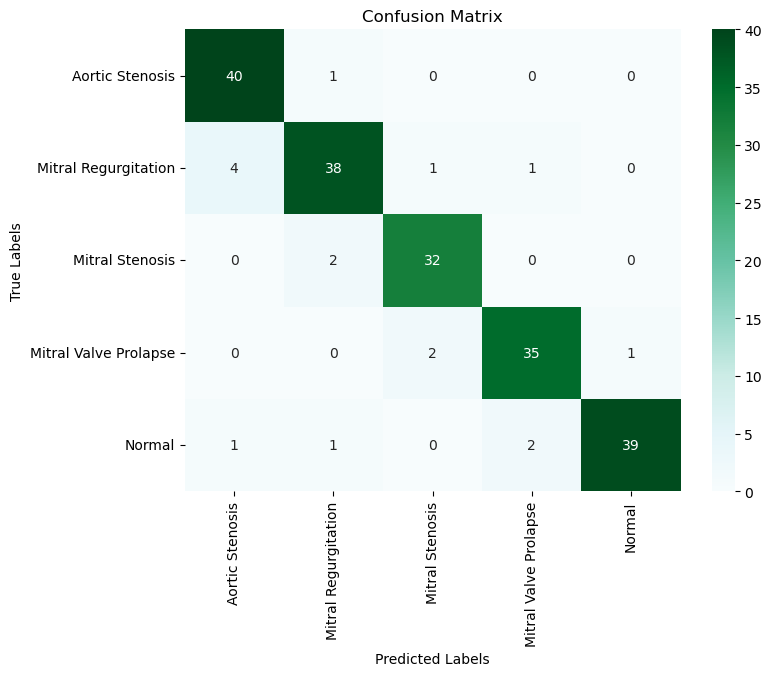

In [10]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="BuGn", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Learning Curves

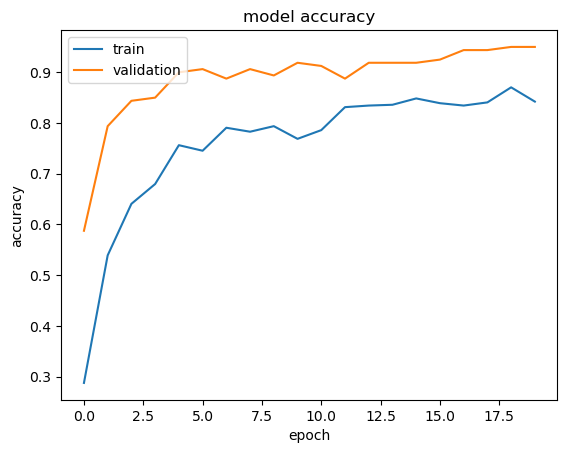

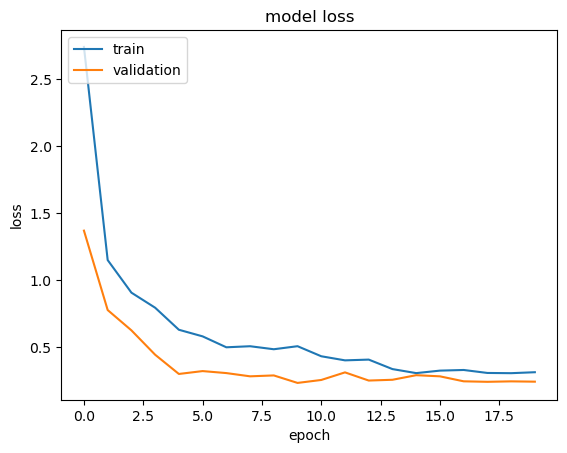

In [11]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()